In [ ]:
# School: University of Amsterdam
# Course: Scientific Data Analysis 2021/2022
# Programmed by: Team 10
# Description: Uses sklearn.linear_model functions on data/Merged.csv to seek
#              correlations between the datasets. Uses the return values to create
#              an adjacency matrix. Creates network from the matrix using networkx

In [99]:
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import csv

In [100]:
def floatCheck(x):
    try:
        float(x)
        return True
    except ValueError:
        return False

with open("data/Merged.csv") as f:
    data = csv.reader(f)
    data = np.array(list(data))
# Categories become headers
headers = list(data[0][1:-1])
# Removes headers and country names.
data = data[1:, 1:]
# Any non-float becomes NaN.
data = [[float(x) if floatCheck(x) else np.nan for x in row] for row in data]
# Divides corona data values by the population of the country.
data = [[x/row[-1] if i > 5 else x for i, x in enumerate(row[:-1])] for row in data]
headers = ["VA", "PV", "GE", "RQ", "RL", "CC", "Tests", "Deaths", "Cases", "Vaccinated", "Fully Vaxed"]
print(headers)

['VA', 'PV', 'GE', 'RQ', 'RL', 'CC', 'Tests', 'Deaths', 'Cases', 'Vaccinated', 'Fully Vaxed']


In [101]:
lenHeaders = len(headers)
# Removes rows which have non-float values for easier use of
# the linear regression functions.
data = np.asarray([row for row in data if not any(np.isnan(x) for x in row)])
print(data)

[[0.554      0.6        0.25       ... 0.06967546 0.73132171 0.33450577]
 [0.1875     0.8        0.75       ... 0.07427713 2.156776   0.88401388]
 [0.62875    0.55       0.375      ... 0.11692869 1.51021825 0.65461136]
 ...
 [0.63375    0.65       0.625      ... 0.04957552 0.42940376 0.24252017]
 [0.4305     0.55       0.25       ... 0.01110929 0.05742967 0.03655978]
 [0.18925    0.2        0.         ... 0.00896736 0.43999236 0.18755022]]


The following 3 code cells were simply to test the functions. They are unused in our research.

In [102]:
columns = data.T
X_train, X_test, y_train, y_test = train_test_split(data[:, 1:], columns[1], test_size=0.2)
clf = Lasso(alpha=1)
clf.fit(X_train, y_train)
r_squared = r2_score(clf.predict(X_test), y_test)
print(r_squared)
print(clf.coef_)

0.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [103]:
clf = Ridge(alpha=1)
clf.fit(X_train, y_train)
r_squared = r2_score(clf.predict(X_test), y_test)
print(r_squared)
print(clf.coef_)

0.9099847437132598
[ 6.25924495e-01  2.49971580e-02  7.58219502e-02  5.72630171e-02
  8.56262236e-02 -1.17894788e-04 -3.67906210e-05 -2.58204224e-02
 -5.10074320e-03  2.62081628e-02]


In [104]:
clf = LinearRegression()
clf.fit(X_train, y_train)
r_squared = r2_score(clf.predict(X_test), y_test)
print(r_squared)
print(clf.coef_)

1.0
[ 1.00000000e+00 -3.06745572e-16 -3.32911322e-16 -2.98673141e-16
 -3.13152760e-16 -2.74814949e-16 -2.27762811e-15 -2.26559648e-17
  1.54287495e-16  6.86177800e-18]


In [105]:
# RidgeSimMatrix will be the adjacency matrix for our networks.
# Each header will become node.
ridgeSimMatrix = [headers.copy()]
for x in range(lenHeaders):
    # Create a ridge function with alpha=1. We found alpha=1 creates a clear
    # difference between bigger and smaller correlations.
    clf = Ridge(alpha=1)
    # Fits the ridge function to the data as best as it can to create a function
    # which best calculates the target column(The current header's).
    clf.fit(np.asarray([row for i,row in enumerate(columns) if i!=x]).T, columns[x])
    # The current header becomes the start of this row.
    ridgeSimRow = [ridgeSimMatrix[0][x]]
    # Coef is a list of slopes the fit uses which we can consider as correlations.
    coefs = list(clf.coef_)
    # Puts the correlations into the row at the correct column.
    for i in range(lenHeaders-1):
        # The first 2 if-statements are to set correlations amongst the datasets
        # themselves to 0, so we can filter their edges out later and highlight
        # the correlations we're interested in.
        if x > 5 and i > 5:
            ridgeSimRow.append(0)
        elif x < 6 and i < 5:
            ridgeSimRow.append(0)
        # While correlations 1 way are similar to correlations the other way,
        # there is a tiny difference. So this if-else combo ensures the result
        # is an adjacency matrix.
        elif x <= i:
            ridgeSimRow.append(abs(coefs[i]))
        else:
            ridgeSimRow.append(ridgeSimMatrix[i+1][x])
    ridgeSimMatrix.append(ridgeSimRow)
# Headers aren't compared with themselves. This inserts a diagonal line of 1s so
# the headers line up correctly.
for i in range(lenHeaders+1):
    ridgeSimMatrix[i].insert(i, 1)
# Converts it to a pd.dataframe purely for better visuals.
ridgeMatrixFramed = pd.DataFrame(ridgeSimMatrix)
print(ridgeMatrixFramed)

             0         1         2         3         4         5         6   \
0             1        VA        PV        GE        RQ        RL        CC   
1            VA         1         0         0         0         0         0   
2            PV         0         1         0         0         0         0   
3            GE         0         0         1         0         0         0   
4            RQ         0         0         0         1         0         0   
5            RL         0         0         0         0         1         0   
6            CC         0         0         0         0         0         1   
7         Tests  0.002826  0.000784  0.004240  0.004767  0.005776  0.001536   
8        Deaths  0.004054  0.001699  0.000723  0.003129  0.000601  0.003428   
9         Cases  0.146809  0.108004  0.031199  0.057568  0.013737  0.010711   
10   Vaccinated  0.041308  0.005137  0.065147  0.020947  0.034599  0.009613   
11  Fully Vaxed  0.001059  0.076030  0.019955  0.120

In [106]:
# Same as with Ridge, but here alpha=0.001 was required for a clear
# difference between bigger and smaller correlations.
lassoSimMatrix = [headers.copy()]
for x in range(lenHeaders):
    clf = Lasso(alpha=0.001)
    clf.fit(np.asarray([row for i,row in enumerate(columns) if i!=x]).T, columns[x])
    lassoSimRow = [lassoSimMatrix[0][x]]
    coefs = list(clf.coef_)
    for i in range(lenHeaders-1):
        if x > 5 and i > 5:
            lassoSimRow.append(0)
        elif x < 6 and i < 5:
            lassoSimRow.append(0)
        elif x <= i:
            lassoSimRow.append(abs(coefs[i]))
        else:
            lassoSimRow.append(lassoSimMatrix[i+1][x])
    lassoSimMatrix.append(lassoSimRow)
for i in range(lenHeaders+1):
    lassoSimMatrix[i].insert(i, 1)
lassoMatrixFramed = pd.DataFrame(lassoSimMatrix)
print(lassoMatrixFramed)

             0         1         2         3         4         5         6   \
0             1        VA        PV        GE        RQ        RL        CC   
1            VA         1         0         0         0         0         0   
2            PV         0         1         0         0         0         0   
3            GE         0         0         1         0         0         0   
4            RQ         0         0         0         1         0         0   
5            RL         0         0         0         0         1         0   
6            CC         0         0         0         0         0         1   
7         Tests  0.003473  0.000035  0.002084  0.004480  0.005309  0.000350   
8        Deaths  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
9         Cases  0.242900  0.089660  0.000000  0.000000  0.000000  0.000000   
10   Vaccinated  0.045753  0.000000  0.050379  0.000000  0.049719  0.028059   
11  Fully Vaxed  0.000000  0.087234  0.000000  0.067

In [107]:
# See Ridge comments.
linRegSimMatrix = [headers.copy()]
for x in range(lenHeaders):
    clf = LinearRegression()
    clf.fit(np.asarray([row for i,row in enumerate(columns) if i!=x]).T, columns[x])
    linRegSimRow = [linRegSimMatrix[0][x]]
    coefs = list(clf.coef_)
    for i in range(lenHeaders-1):
        if x > 5 and i > 5:
            linRegSimRow.append(0)
        elif x < 6 and i < 5:
            linRegSimRow.append(0)
        elif x <= i:
            linRegSimRow.append(abs(coefs[i]))
        else:
            linRegSimRow.append(linRegSimMatrix[i+1][x])
    linRegSimMatrix.append(linRegSimRow)
for i in range(lenHeaders+1):
    linRegSimMatrix[i].insert(i, 1)
linRegMatrixFramed = pd.DataFrame(linRegSimMatrix)
print(linRegMatrixFramed)

             0          1         2         3          4          5   \
0             1         VA        PV        GE         RQ         RL   
1            VA          1         0         0          0          0   
2            PV          0         1         0          0          0   
3            GE          0         0         1          0          0   
4            RQ          0         0         0          1          0   
5            RL          0         0         0          0          1   
6            CC          0         0         0          0          0   
7         Tests   0.004832  0.002450  0.002038   0.005853   0.003377   
8        Deaths  24.371196  5.703155  4.933911  29.363524  12.140900   
9         Cases   0.332603  0.542312  0.198792   0.180615   0.222191   
10   Vaccinated   0.030146  0.048879  0.113867   0.173311   0.015515   
11  Fully Vaxed   0.088645  0.237008  0.142764   0.442504   0.146866   

           6         7          8         9           10       

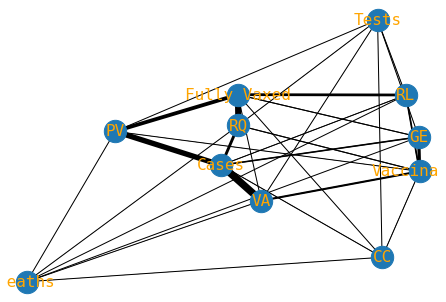

In [108]:
# Formats the adjacency matrix for the matrix to graph converter.
# Each values is used as a width for the line and for spring_layout edge
# lengths. We found a multiplication of that 50 creates the best widths.
adjMatrix = [[x*50 for x in row] for row in np.asarray(ridgeSimMatrix)[1:, 1:].astype(np.float)]
G = nx.from_numpy_matrix(np.matrix(adjMatrix))

layout = nx.spring_layout(G)
# Creates a node for each header.
lab_node = dict(zip(G.nodes, headers))
# Selects every edges with a value of 0.
long_edges = list(filter(lambda e: e[2] == 0, (e for e in G.edges.data('weight'))))
le_ids = list(e[:2] for e in long_edges)

# remove selected edges from graph G.
G.remove_edges_from(le_ids)
# Draws the graph.
nx.draw(G, layout)
nx.draw_networkx_nodes(G, layout, node_size=500)
widths = list(nx.get_edge_attributes(G, "weight").values())
nx.draw_networkx_edges(G, layout, width=widths)
nx.draw_networkx_labels(G, layout, labels=lab_node, font_size=16, font_family='monospace', font_color="orange")
plt.show()

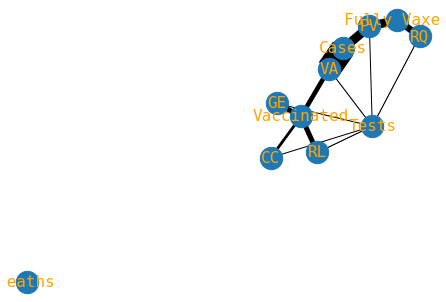

In [109]:
# See code cell above for comments
adjMatrix = [[x*100 for x in row] for row in np.asarray(lassoSimMatrix)[1:, 1:].astype(np.float)]
G = nx.from_numpy_matrix(np.matrix(adjMatrix))

layout = nx.spring_layout(G)
lab_node = dict(zip(G.nodes, headers))
long_edges = list(filter(lambda e: e[2] == 0, (e for e in G.edges.data('weight'))))
le_ids = list(e[:2] for e in long_edges)

G.remove_edges_from(le_ids)
nx.draw(G, layout)
nx.draw_networkx_nodes(G, layout, node_size=500)
widths = list(nx.get_edge_attributes(G, "weight").values())
nx.draw_networkx_edges(G, layout, width=widths)
nx.draw_networkx_labels(G, layout, labels=lab_node, font_size=16, font_family='monospace', font_color="orange")
plt.show()

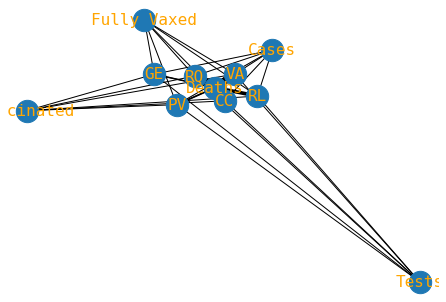

In [111]:
# See 2 code cells above for comments.
adjMatrix = [[x*0.3 for x in row] for row in np.asarray(linRegSimMatrix)[1:, 1:].astype(np.float)]
G = nx.from_numpy_matrix(np.matrix(adjMatrix))

layout = nx.spring_layout(G)
lab_node = dict(zip(G.nodes, headers))
long_edges = list(filter(lambda e: e[2] == 0, (e for e in G.edges.data('weight'))))
le_ids = list(e[:2] for e in long_edges)

G.remove_edges_from(le_ids)
nx.draw(G, layout)
nx.draw_networkx_nodes(G, layout, node_size=500)
widths = list(nx.get_edge_attributes(G, "weight").values())
nx.draw_networkx_edges(G, layout, width=widths)
nx.draw_networkx_labels(G, layout, labels=lab_node, font_size=16, font_family='monospace', font_color="orange")
plt.show()